## Importing libraries and dataset

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

## Implementation of generator and discriminator

In [103]:
class Generator(nn.Module):
    def __init__(self, img_dim, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

    def sample(self, B):
        x = torch.randn(B, self.latent_dim).to(device)
        x = self.forward(x)
        return x

In [104]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [105]:
def generateSamples(generator, num_samples=18):
    x = generator.sample(num_samples)
    return x

def plotSamples(x, M=6, N=3):
    fig, ax = plt.subplots(N, M, figsize=(M, N * 1.3), sharex=True, sharey=True)
    for i in range(N):
        for j in range(M):
            ax[i, j].imshow(x[i * 3 + j].permute(1, 2, 0), cmap="gray")
    plt.show()

## Training

In [106]:
img_dim = 28 * 28
num_epochs = 10
batch_size = 16
latent_dim = 100
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device using: {device}")

Device using: cuda


In [107]:
generator = Generator(img_dim, latent_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

Generated image before training:

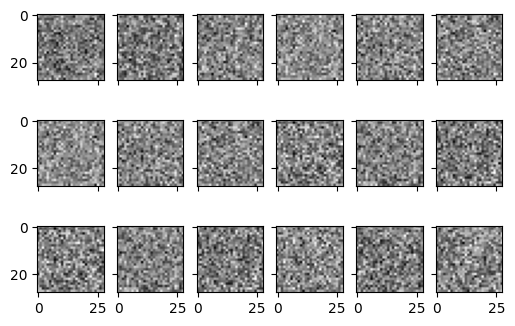

In [108]:
x_fake = generator.sample(18).view(-1, 1, 28, 28).cpu().detach()
plotSamples(x_fake)

In [109]:
opt_gen = optim.Adam(generator.parameters(), lr=lr)
opt_dis = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()
d_history = []
g_history = []

In [116]:
for epoch in range(10):
    loss_d = 0.0
    loss_g = 0.0
    n = 0
    for batch_idx, data in enumerate(trainloader):
        X, _ = data
        X = X.view(-1, img_dim)
        X = X.to(device).float()

        X_fake = torch.randn(batch_size, latent_dim).to(device)
        X_fake = generator(X_fake)
        d_loss = criterion(discriminator(X), torch.ones(batch_size, 1).to(device)) + criterion(discriminator(X_fake), torch.zeros(batch_size, 1).to(device))
        opt_dis.zero_grad()
        d_loss.backward(retain_graph=True)
        opt_dis.step()

        g_loss = criterion(discriminator(X_fake), torch.ones(batch_size, 1).to(device))
        opt_gen.zero_grad()
        g_loss.backward(retain_graph=True)
        opt_gen.step()

        loss_d += d_loss.item()
        loss_g += g_loss.item()
        n += 1

    d_history.append(loss_d / n)
    g_history.append(loss_g / n)
    print(f"Epoch {epoch} with discriminator loss: {loss_d / n} and generator loss: {loss_g / n}")

Epoch 0 with discriminator loss: 1.2527686857382456 and generator loss: 1.1610211795806884
Epoch 1 with discriminator loss: 1.237606134637197 and generator loss: 1.1894347504933676
Epoch 2 with discriminator loss: 1.235488564157486 and generator loss: 1.1963230208476385
Epoch 3 with discriminator loss: 1.231885284169515 and generator loss: 1.1892162604014078
Epoch 4 with discriminator loss: 1.2210118246555328 and generator loss: 1.2077306669314702
Epoch 5 with discriminator loss: 1.2093269089539846 and generator loss: 1.2215900881369908
Epoch 6 with discriminator loss: 1.213018281173706 and generator loss: 1.214098542658488
Epoch 7 with discriminator loss: 1.2127723609288534 and generator loss: 1.2218310621420543
Epoch 8 with discriminator loss: 1.2111199197610218 and generator loss: 1.2280429807504019
Epoch 9 with discriminator loss: 1.2075091294447582 and generator loss: 1.2424702990531922


The model is trained for 30 epochs. The training loss curve for the discriminator and the generator is shown below.

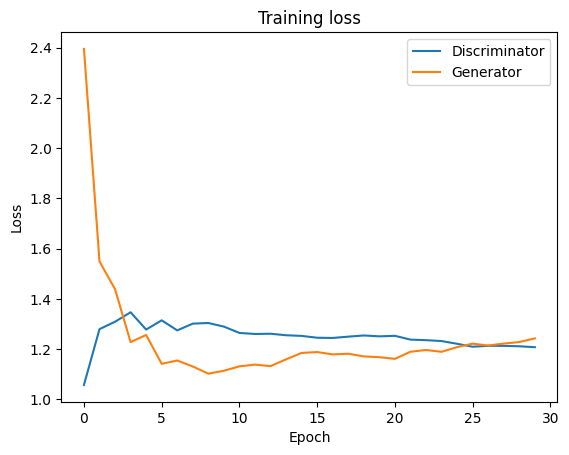

In [117]:
plt.plot(d_history, label="Discriminator")
plt.plot(g_history, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.legend()
plt.show()

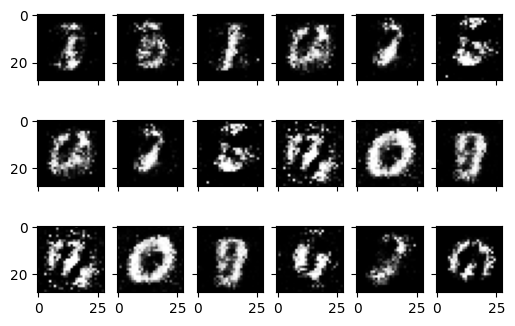

In [112]:
# After 10 epochs
x_fake = generator.sample(18).view(-1, 1, 28, 28).cpu().detach()
fig, ax = plt.subplots(3, 6, figsize=(6, 3 * 1.3), sharex=True, sharey=True)
for i in range(3):
    for j in range(6):
        ax[i, j].imshow(x_fake[i * 3 + j].permute(1, 2, 0), cmap="gray")
plt.show()

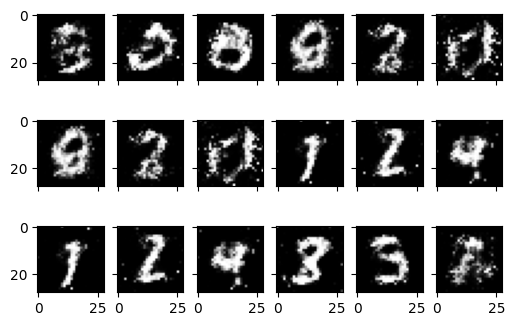

In [114]:
# After 20 epochs
x_fake = generator.sample(18).view(-1, 1, 28, 28).cpu().detach()
fig, ax = plt.subplots(3, 6, figsize=(6, 3 * 1.3), sharex=True, sharey=True)
for i in range(3):
    for j in range(6):
        ax[i, j].imshow(x_fake[i * 3 + j].permute(1, 2, 0), cmap="gray")
plt.show()

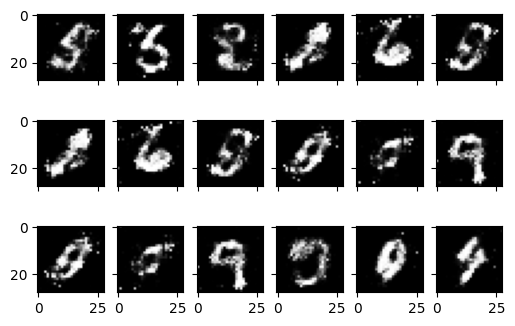

In [118]:
# After 30 epochs
x_fake = generator.sample(18).view(-1, 1, 28, 28).cpu().detach()
fig, ax = plt.subplots(3, 6, figsize=(6, 3 * 1.3), sharex=True, sharey=True)
for i in range(3):
    for j in range(6):
        ax[i, j].imshow(x_fake[i * 3 + j].permute(1, 2, 0), cmap="gray")
plt.show()